In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from skimage import io as skio
from skimage import transform as sktf

In [2]:
!ls -la

total 16
drwxr-xr-x  5 avneesh  staff   160 Jun 29 07:07 .
drwxr-xr-x@ 7 avneesh  staff   224 Jun 28 21:04 ..
-rw-r--r--@ 1 avneesh  staff  6148 Jun 29 06:57 .DS_Store
drwxr-xr-x@ 5 avneesh  staff   160 Jun 29 07:38 data
drwxr-xr-x@ 5 avneesh  staff   160 Jun 28 21:09 figures


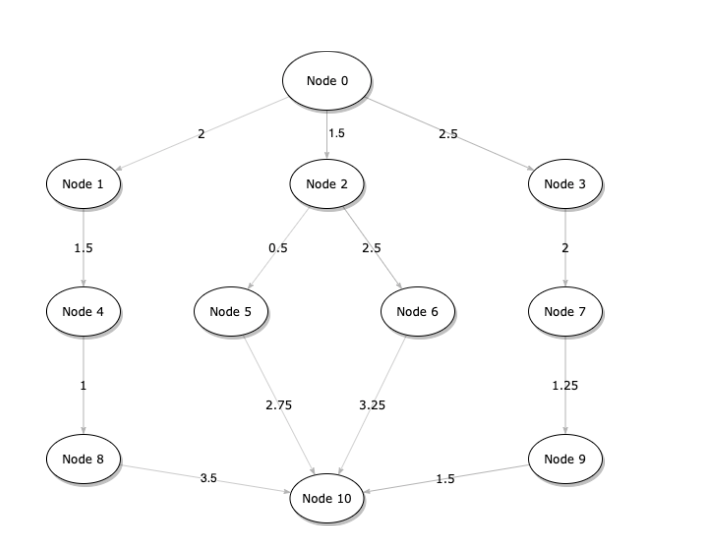

In [3]:
Image('./figures/graph.png')

We are going to use networkx package to construct the graph and find the shortest paths. Refer to the [NetworkX documentation](https://networkx.github.io/documentation/stable/).

In [4]:
#type in the edges and edgecost as a list of 3-tuples
edges = [
         (0, 1, 2), (0, 2, 1.5), (0, 3, 2.5),
         (1, 4, 1.5),
         (2, 5, 0.5), (2, 6, 2.5),
         (3, 7, 2),
         (4, 8, 1),
         (5, 10, 2.75),
         (6, 10, 3.25),
         (7, 9, 1.25),
         (8, 10, 3.5),
         (9, 10, 1.5)
]

#Define an empty graph
G =nx.Graph()

#populate the edges and the cost in graph G
G.add_weighted_edges_from(edges, weight='cost')   

#Find the shortest path from Node 0 to Node 10
print(nx.shortest_path(G, 0, 10, 'cost'))

#Find the cost of the shortest path from Node 0 to Node 10
print(nx.shortest_path_length(G, 0, 10, 'cost'))


[0, 2, 5, 10]
4.75


Let us now move onto a grid which represents the robot's operating environment. First convert the grid to a graph.  Then we will use Astar from networkX to find the shortest path

In [5]:
# write the Euclidean function that takes in the
# node x, y and compute the distance
def euclidean(node1, node2):
  x1, y1 = node1
  x2, y2 = node2
  return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [6]:
!ls ./data

astar_grid.npy brc202d.png    brc204d.png


In [7]:
# use np.load to load a grid of 1s and 0s
# 1 - occupied 0- free
grid = np.load("./data/astar_grid.npy")
print(grid.shape)

(20, 20)


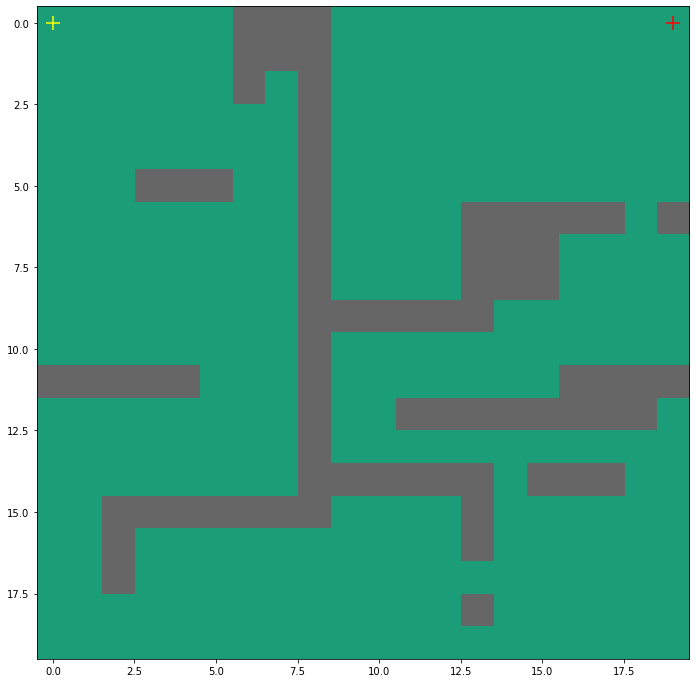

In [8]:
# you can define your own start/ end
start = (0, 0)
goal = (0, 19)

# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

Convert this grid array into a graph. You have to follow these steps
1. Find the dimensions of grid. Use grid_2d_graph() to initialize a grid graph of corresponding dimensions
2. Use remove_node() to remove nodes and edges of all cells that are occupied

In [9]:
#initialize graph
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)
# G.nodes -> (0,0), (0,1), ... (19, 18), (19, 19)
num_nodes = 0 # counter to keep track of deleted nodes
#nested loop to remove nodes that are not connected
#free cell => grid[i, j] = 0
#occupied cell => grid[i, j] = 1
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i, j] == 1: # If occupied
      G.remove_node((i, j))
      num_nodes += 1

print(f"Removed {num_nodes} nodes")
print(f"Number of occupied cells in grid {np.sum(grid)}")

Removed 77 nodes
Number of occupied cells in grid 77


Visualize the resulting graph using nx.draw(). Note that pos argument for nx.draw() has been given below. The graph is too dense. Try changing the node_size and node_color. You can correlate this graph with the grid's occupied cells

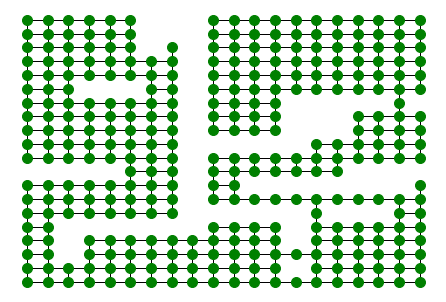

In [10]:
pos = {(x,y):(y,-x) for x,y in G.nodes()} # Converting axis
nx.draw(G, pos=pos, node_color='green', node_size=100)

We are 2 more steps away from finding the path!
1. Set edge attribute.  Use set_edge_attributes(). Remember we have to provide a dictionary input: Edge is the key and cost is the value. We can set every move to a neighbor to have unit cost.
2. Use astar_path() to find the path. Set heuristic to be euclidean distance. weight to be the attribute you assigned in step 1

In [11]:
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, "cost")  # All edges have cost = 1
weight = 1.0  # Weight for heuristic
astar_path = nx.astar_path(G, start, goal, 
                  heuristic=lambda n1, n2: weight * euclidean(n1, n2), 
                  weight="cost")

In [12]:
print(astar_path)

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]


Visualize the path you have computed!

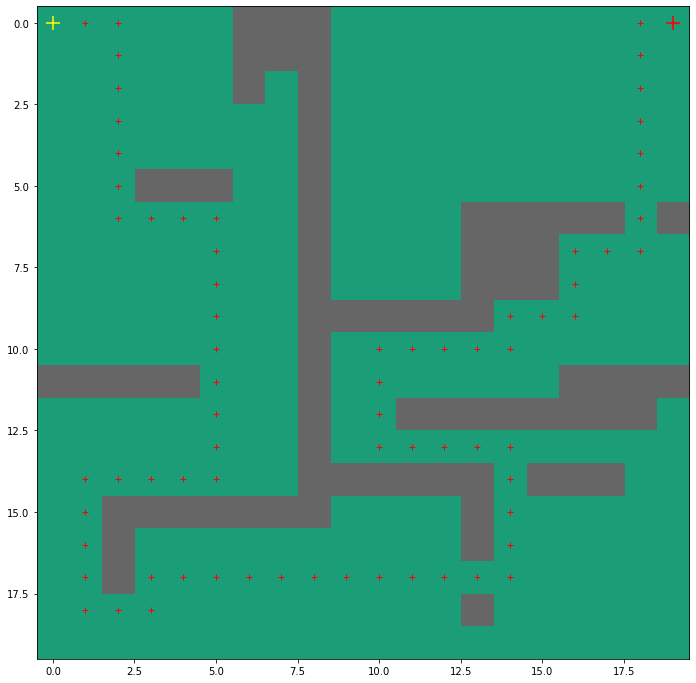

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')

Create and visualize a dijkstra path

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]


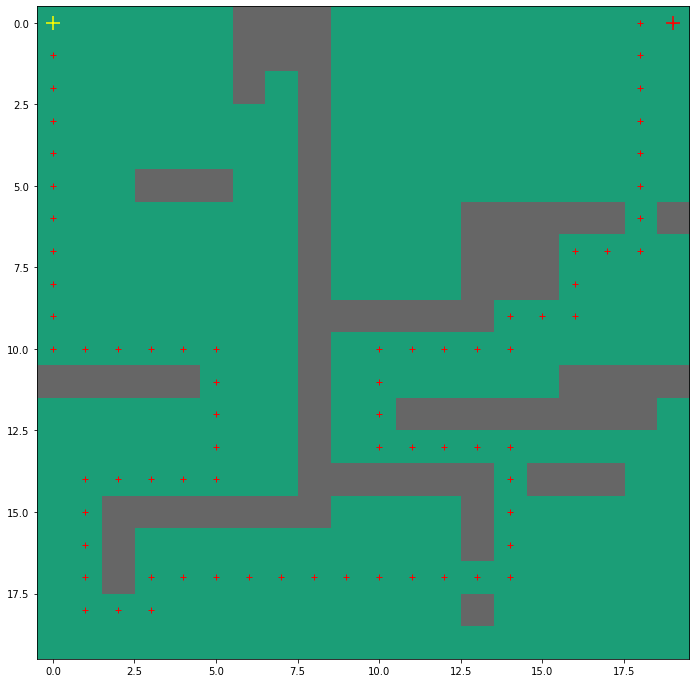

In [14]:
dijkstra_path = nx.dijkstra_path(G, start, goal, weight='cost')
print(dijkstra_path)
# Visualize it
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in dijkstra_path[1:]: # plot all points
  ax.plot(s[1], s[0],'r+')

Cool! Now you can read arbitrary evironments and find the shortest path between 2 robot positions. Pick a game environment from here and repeat: https://www.movingai.com/benchmarks/dao/index.html

In [15]:
!ls -la ./data/

total 168
drwxr-xr-x@ 5 avneesh  staff    160 Jun 29 07:38 .
drwxr-xr-x  5 avneesh  staff    160 Jun 29 07:07 ..
-rw-rw-r--@ 1 avneesh  staff   3328 Jun 25 22:32 astar_grid.npy
-rw-r--r--@ 1 avneesh  staff  44483 Jun 29 06:56 brc202d.png
-rw-r--r--@ 1 avneesh  staff  36339 Jun 29 07:38 brc204d.png


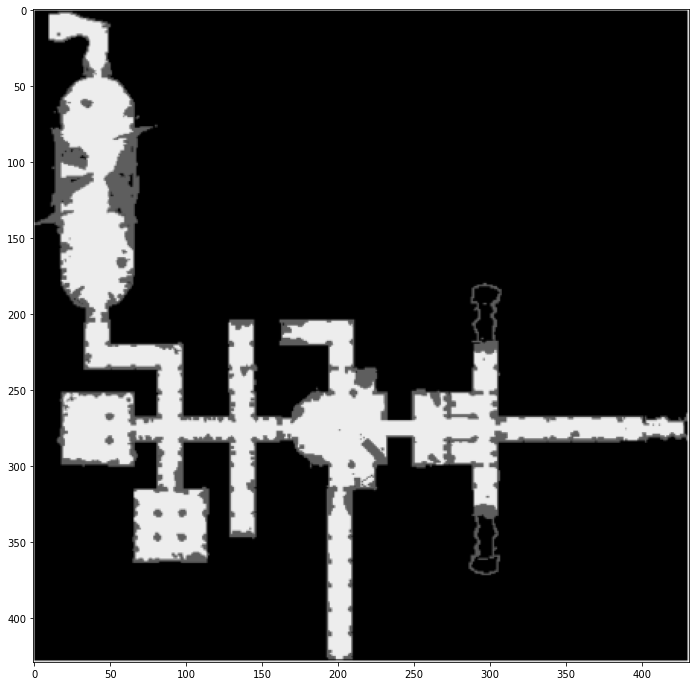

In [16]:
img = skio.imread("./data/brc204d.png", as_gray=True)
img = sktf.resize(img, (429, 431))  # Original size
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img, cmap=plt.cm.gray)

In [17]:
G = nx.grid_2d_graph(*(img.shape))  # Graph

Threshold the graph and remove nodes that are outside path

In [18]:
# Threshold and transform occupancy grid to nx graph
# Occupied -> img < 0.5
# Free -> img > 0.5
for row in range(img.shape[0]):
  for col in range(img.shape[1]):
    if img[row, col] < 0.5: # in the black area above
      G.remove_node((row, col))

Define start and goal positions

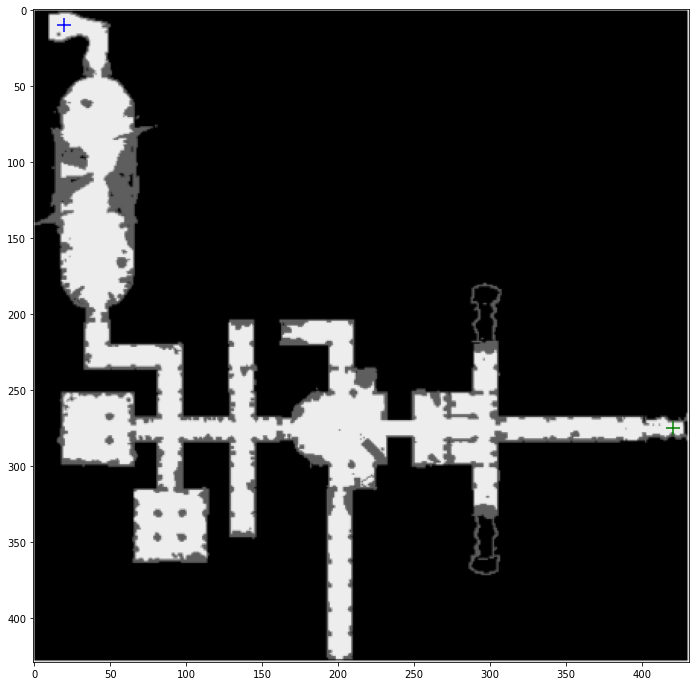

In [19]:
start = (10, 20)
goal = (275, 420)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img, cmap=plt.cm.gray)
ax.scatter(start[1], start[0], marker='+', color="blue", s=200)
ax.scatter(goal[1], goal[0], marker='+', color="green", s=200)

Run an A* path search from the start to goal node in the graph `G`

In [20]:
nx.set_edge_attributes(G, 1, "cost")
weight = 1.0
astar_path = nx.astar_path(G, start, goal, 
                  heuristic= lambda n1, n2: weight*euclidean(n1, n2),
                  weight="cost")

Visualize the astar path

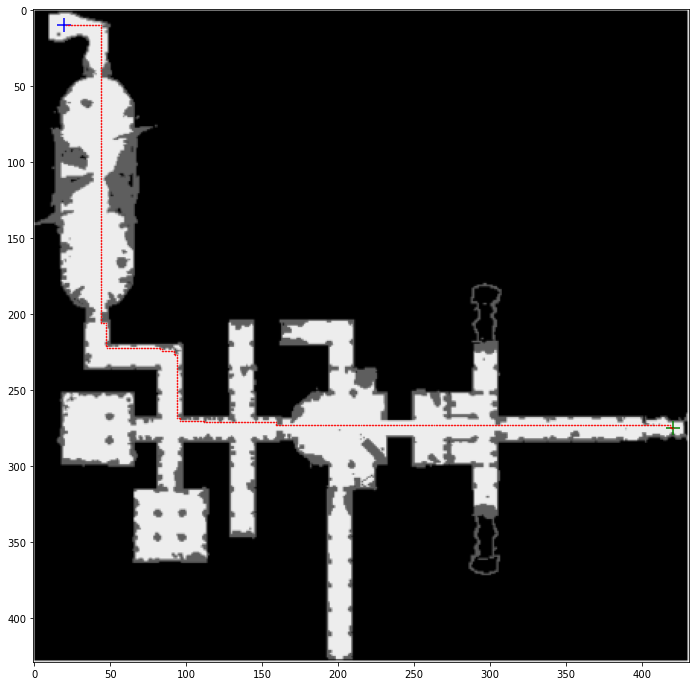

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img, cmap=plt.cm.gray)
ax.scatter(start[1], start[0], marker='+', color="blue", s=200)
ax.scatter(goal[1], goal[0], marker='+', color="green", s=200)
for s in astar_path[1:]: # plot all points
  ax.plot(s[1], s[0],'r.', markersize=1)